In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v5 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Source

In [3]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math
import os
import utils
#from utils import plotLearning

#from dueling_dqn_torch import Agent

In [4]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 0.         -0.          0.         -0.          0.02       -0.
  0.11059734  0.         -0.         -0.00191829]


In [5]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,n_actions):
    self.mem_size = max_size
    self.mem_cntr= 0 
    self.state_memory =np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size,dtype = np.int64)
    self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size , dtype = np.uint8)

  def store_transition(self,state,action,reward,new_state,done):
    index=self.mem_cntr % self.mem_size

    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.new_state_memory[index] = new_state
    self.terminal_memory[index]=done

    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min (self.mem_cntr,self.mem_size)
    batch = np.random.choice(max_mem,batch_size,replace=False)
    
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    new_states = self.new_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, actions, rewards ,new_states ,dones

In [14]:
class DuelingLinearDeepQNetwork(nn.Module):
  def __init__(self, ALPHA, n_actions , name , input_dims , chkpt_dir ='tmp/dueling_dqn'):
    super(DuelingLinearDeepQNetwork,self).__init__()

    self.fc1 = nn.Linear(*input_dims,128)
    self.fc2 =nn.Linear(128,128)
    self.V =nn.Linear(128,1)
    self.A=nn.Linear(128,n_actions)
    
    self.optimizer = optim.Adam(self.parameters() , lr =ALPHA)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir,name+'dueling')

  def forward(self,state):
    l1 = F.relu(self.fc1(state))
    l2 = F.relu(self.fc2(l1))
    V= self.V(l2)
    A= self.A(l2)

    return V,A

  def save_checkpoint(self):
    print('save checkpoint ...')
    T.save(self.state_dict(),self.checkpoint_file)


  def load_checkpoint(self):
    print('load checkpoint ...')
    self.load_state_dict(T.load(self.checkpoint_file))

In [7]:
class Agent(object):
  def __init__(self,gamma,epsilon,alpha,n_actions,input_dims,mem_size,batch_size,eps_min=0.01,eps_dec = 5e-7,replace =1000,chkpt_dir = 'tmp/dueling_dqn'):

    self.gamma = gamma 
    self.epsilon=epsilon
    self.eps_min=eps_min
    self.eps_dec=eps_dec
    self.action_space =[i for i in range(n_actions)]
    self.learn_step_counter = 0
    self.replace_target_cnt = replace
    self.batch_size=batch_size
    self.memory = ReplayBuffer(mem_size,input_dims,n_actions)
    self.q_eval = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_eval' , chkpt_dir =chkpt_dir )

    self.q_next = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_next' , chkpt_dir =chkpt_dir )


  def store_transition(self,state,action,reward, state_ , done):
    self.memory.store_transition(state,action,reward, state_ , done)

  def choose_action(self,observation):
    if np.random.random() > self.epsilon :
        observation = observation[np.newaxis, :]
        state = T.tensor(observation).to(self.q_eval.device)
        _,advantage =self.q_eval.forward(state)
        action = T.argmax(advantage).item()
    else:
        action = np.random.choice(self.action_space)
    return action

  def replace_target_network(self):
      if self.replace_target_cnt is not None and self.learn_step_counter % self.replace_target_cnt == 0:
        self.q_next.load_state_dict(self.q_eval.state_dict())
      
  def decremen_epsilon(self):
      self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  
  def learn(self):
      if self.memory.mem_cntr  <self.batch_size:
        return
      
      self.q_eval.optimizer.zero_grad()
      self.replace_target_network()

      state,action,reward,new_state,done =self.memory.sample_buffer(self.batch_size)

      state=T.tensor(state).to(self.q_eval.device)
      new_state = T.tensor(new_state).to(self.q_eval.device)
      action = T.tensor(action).to(self.q_eval.device)
      reward = T.tensor(reward).to(self.q_eval.device)
      dones= T.tensor(done).to(self.q_eval.device)

      V_s,A_s = self.q_eval.forward(state)
      V_s_ ,A_s_ = self.q_next.forward(new_state)

      q_pred = T.add(V_s,(A_s-A_s.mean(dim=1 , keepdim=True))).gather(1,action.unsqueeze(-1)).squeeze(-1)

      q_next = T.add(V_s_,(A_s_-A_s_.mean(dim=1 , keepdim=True)))

      q_target = reward + self.gamma*T.max(q_next , dim=1)[0].detach()
      q_target[dones] = 0.0

      loss = self.q_eval.loss(q_target,q_pred).to(self.q_eval.device)
      loss.backward()
      self.q_eval.optimizer.step()
      self.learn_step_counter +=1

      self.decremen_epsilon()

  def save_models(self):
      self.q_eval.save_checkpoint()
      self.q_next.save_checkpoint()

  def load_models(self):
      self.q_eval.load_checkpoint()
      self.q_next.load_checkpoint()


In [8]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)


shout entos periohis Ball Position 0.6656852 -0.031069484 0.110420614 episode 0 step= 97
goal episode 0 step= 107
---Avg reward last: 18.851261004855726 Avg score last 1.0 Avg steps 108.0 episode= 0 ---
shout entos periohis Ball Position 0.6909378 -0.001853139 0.110361926 episode 1 step= 107
goal episode 1 step= 116
shout entos periohis Ball Position 0.67168784 -0.08351118 0.10834471 episode 2 step= 107
goal episode 2 step= 118
shout entos periohis Ball Position 0.67585456 -0.04229894 0.11200062 episode 3 step= 108
goal episode 3 step= 118
shout entos periohis Ball Position 0.66128975 -0.06412451 0.11016753 episode 4 step= 97
ball is out -10 episode 4 Ball Position 0.98994243 -0.05000822 0.28858194 step= 108
shout entos periohis Ball Position 0.7536439 -0.056146715 0.111052684 episode 5 step= 114
goal episode 5 step= 123
shout entos periohis Ball Position 0.7782965 0.048950803 0.13274565 episode 6 step= 123
goal episode 6 step= 132
shout entos periohis Ball Position 0.66249156 -0.02828

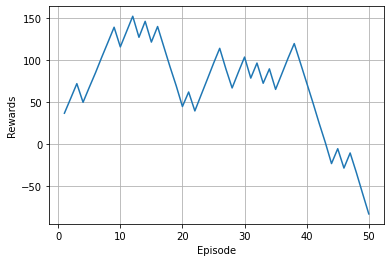

ball is out -10 episode 51 Ball Position 1.0107869 -0.15224929 0.11808457 step= 159
shout entos periohis Ball Position 0.9829842 -0.12536132 0.112647325 episode 52 step= 156
ball is out -10 episode 52 Ball Position 1.0077742 -0.094979994 0.25921234 step= 160
goal episode 53 step= 156
shout entos periohis Ball Position 0.99374557 -0.042311758 0.11280023 episode 54 step= 148
goal episode 54 step= 151
goal episode 55 step= 159
shout entos periohis Ball Position 0.9509338 0.06213288 0.12372298 episode 56 step= 150
ball is out -10 episode 56 Ball Position 0.9800527 0.07648113 0.14705075 step= 154
shout entos periohis Ball Position 0.73978627 -0.05374521 0.112187825 episode 57 step= 118
goal episode 57 step= 127
shout entos periohis Ball Position 0.8432884 0.030186616 0.12290072 episode 58 step= 135
ball is out -10 episode 58 Ball Position 1.0125715 0.06371255 0.10958347 step= 144
ball is out -10 episode 59 Ball Position 1.0127554 -0.112184234 0.11988773 step= 146
shout entos periohis Ball P

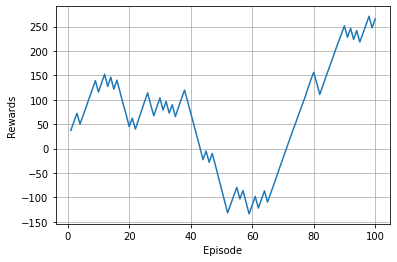

shout entos periohis Ball Position 0.77343637 0.025919003 0.11231548 episode 101 step= 116
goal episode 101 step= 127
shout entos periohis Ball Position 0.75495756 0.05322896 0.10689394 episode 102 step= 119
goal episode 102 step= 127
shout entos periohis Ball Position 0.662375 0.008916091 0.1266478 episode 103 step= 103
goal episode 103 step= 116
shout entos periohis Ball Position 0.66231775 -0.012142965 0.11602697 episode 104 step= 108
goal episode 104 step= 121
goal episode 105 step= 150
shout entos periohis Ball Position 0.83761346 0.079241835 0.11890365 episode 106 step= 124
ball is out -10 episode 106 Ball Position 0.9977226 0.07342172 1.0024651 step= 131
shout entos periohis Ball Position 0.8226804 0.011431988 0.11893706 episode 107 step= 126
ball is out -10 episode 107 Ball Position 0.9922939 0.043592244 0.1157222 step= 133
shout entos periohis Ball Position 0.66661173 -0.06944325 0.12694588 episode 108 step= 102
goal episode 108 step= 113
shout entos periohis Ball Position 0.6

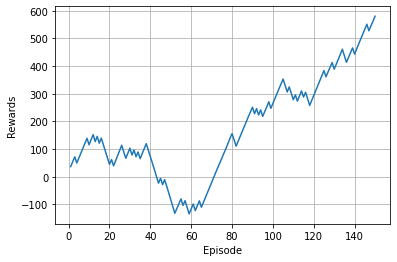

shout entos periohis Ball Position 0.6595471 0.0063153845 0.112302735 episode 151 step= 103
goal episode 151 step= 114
shout entos periohis Ball Position 0.6601127 0.058246776 0.1099252 episode 152 step= 98
ball is out -10 episode 152 Ball Position 1.012025 0.059307028 0.3038452 step= 110
shout entos periohis Ball Position 0.6583751 0.01813978 0.11030116 episode 153 step= 102
goal episode 153 step= 115
shout entos periohis Ball Position 0.68807036 -0.046202067 0.11230047 episode 154 step= 110
ball is out -10 episode 154 Ball Position 0.99899745 -0.06508651 0.15485837 step= 122
shout entos periohis Ball Position 0.9472211 0.034346443 0.11567238 episode 155 step= 133
goal episode 155 step= 137
shout entos periohis Ball Position 0.9577142 0.019365631 0.11981683 episode 156 step= 139
goal episode 156 step= 143
shout entos periohis Ball Position 0.9761525 -0.05580277 0.12993072 episode 157 step= 143
ball is out -10 episode 157 Ball Position 1.010925 -0.0558779 0.111097574 step= 147
shout en

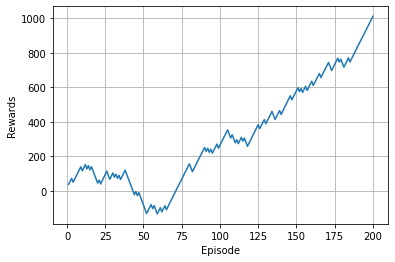

shout entos periohis Ball Position 0.86992383 0.0021012505 0.13349862 episode 201 step= 135
goal episode 201 step= 140
shout entos periohis Ball Position 0.6603004 -0.05090168 0.11884724 episode 202 step= 101
goal episode 202 step= 115
shout entos periohis Ball Position 0.657593 -0.06707088 0.11473797 episode 203 step= 107
goal episode 203 step= 118
shout entos periohis Ball Position 0.73016995 -0.03807004 0.10852732 episode 204 step= 116
ball is out -10 episode 204 Ball Position 0.9838092 -0.06363072 0.553774 step= 125
shout entos periohis Ball Position 0.72028476 -0.038893916 0.12243938 episode 205 step= 119
ball is out -10 episode 205 Ball Position 1.0133197 -0.21871863 0.13485353 step= 161
shout entos periohis Ball Position 0.6710046 -0.019222636 0.12596244 episode 206 step= 108
ball is out -10 episode 206 Ball Position 0.99589944 -0.059649754 0.12882365 step= 120
goal episode 207 step= 147
shout entos periohis Ball Position 0.9321904 -0.054527413 0.12782165 episode 208 step= 144
b

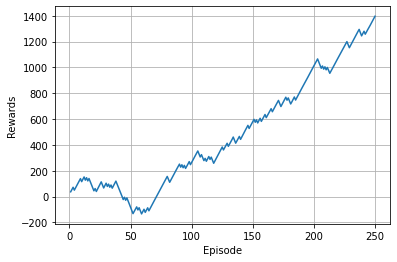

shout entos periohis Ball Position 0.8666664 -0.025422247 0.11235282 episode 251 step= 137
goal episode 251 step= 142
shout entos periohis Ball Position 0.6829598 0.011103243 0.12471635 episode 252 step= 106
goal episode 252 step= 118
shout entos periohis Ball Position 0.8173227 0.021364301 0.12329538 episode 253 step= 114
goal episode 253 step= 120
shout entos periohis Ball Position 0.82798487 -0.024657277 0.12411234 episode 254 step= 135
goal episode 254 step= 141
shout entos periohis Ball Position 0.66798884 -0.08399673 0.11055217 episode 255 step= 105
goal episode 255 step= 115
shout entos periohis Ball Position 0.834041 -0.02234927 0.103455864 episode 256 step= 129
goal episode 256 step= 135
shout entos periohis Ball Position 0.66536856 -0.020315072 0.12430026 episode 257 step= 101
goal episode 257 step= 113
shout entos periohis Ball Position 0.660735 0.04131861 0.11712126 episode 258 step= 102
goal episode 258 step= 115
shout entos periohis Ball Position 0.6740531 0.049422443 0.1

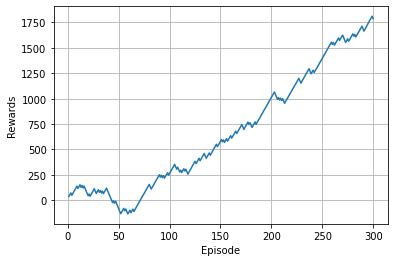

shout entos periohis Ball Position 0.8183391 -0.017723242 0.11742105 episode 301 step= 126
goal episode 301 step= 133
ball is out -10 episode 302 Ball Position 1.0079178 -0.066461675 0.11747456 step= 153
shout entos periohis Ball Position 0.704684 0.009736387 0.12938483 episode 303 step= 115
goal episode 303 step= 124
shout entos periohis Ball Position 0.65992 -0.026427034 0.11203689 episode 304 step= 106
goal episode 304 step= 117
shout entos periohis Ball Position 0.7206959 0.038732406 0.1206679 episode 305 step= 119
goal episode 305 step= 127
ball is out -10 episode 306 Ball Position 1.0153239 -0.09776802 0.12660447 step= 161
shout entos periohis Ball Position 0.66277117 0.0215199 0.117723085 episode 307 step= 102
ball is out -10 episode 307 Ball Position 1.0146868 -0.17505857 0.119887374 step= 160
shout entos periohis Ball Position 0.6580989 0.021179054 0.12798473 episode 308 step= 106
goal episode 308 step= 116
shout entos periohis Ball Position 0.663581 -0.018283227 0.11078124 ep

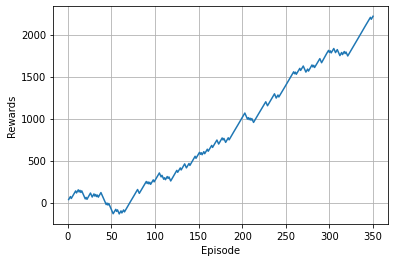

shout entos periohis Ball Position 0.6788917 0.016450927 0.10740958 episode 351 step= 99
goal episode 351 step= 109
shout entos periohis Ball Position 1.006015 -0.03951243 0.11030313 episode 352 step= 145
goal episode 352 step= 146
shout entos periohis Ball Position 0.662976 0.09438239 0.11029694 episode 353 step= 93
ball is out -10 episode 353 Ball Position 1.0017496 0.05054067 0.23011202 step= 107
shout entos periohis Ball Position 0.7632894 0.052922234 0.11274896 episode 354 step= 121
ball is out -10 episode 354 Ball Position 1.0201558 0.045408603 0.11350335 step= 130
shout entos periohis Ball Position 0.8002687 -0.01701022 0.12010398 episode 355 step= 127
goal episode 355 step= 134
goal episode 356 step= 145
shout entos periohis Ball Position 0.74815154 -0.1504792 0.11978757 episode 357 step= 120
ball is out -10 episode 357 Ball Position 1.0180067 -0.11473815 0.16522674 step= 131
shout entos periohis Ball Position 0.80884576 -0.04237873 0.11234056 episode 358 step= 130
goal episode

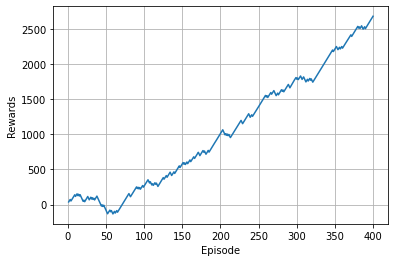

shout entos periohis Ball Position 0.66045564 -0.012029946 0.11845401 episode 401 step= 93
ball is out -10 episode 401 Ball Position 1.0122365 -0.052040942 0.10978552 step= 107
ball is out -10 episode 402 Ball Position 1.0082321 -0.059229836 0.11041995 step= 153
shout entos periohis Ball Position 0.6634804 -0.008298604 0.11488919 episode 403 step= 101
ball is out -10 episode 403 Ball Position 1.0172956 -0.057812728 0.28810745 step= 114
shout entos periohis Ball Position 0.6581284 -0.023610126 0.11569943 episode 404 step= 100
goal episode 404 step= 110
shout entos periohis Ball Position 0.6586623 -0.061799545 0.12971373 episode 405 step= 101
goal episode 405 step= 112
shout entos periohis Ball Position 0.7698552 -0.02606103 0.12243761 episode 406 step= 118
goal episode 406 step= 125
shout entos periohis Ball Position 0.77218777 0.017513948 0.12370333 episode 407 step= 126
goal episode 407 step= 134
shout entos periohis Ball Position 0.8032138 -0.045087527 0.12791793 episode 408 step= 12

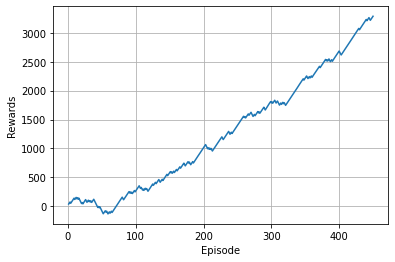

shout entos periohis Ball Position 0.65851027 -0.037070103 0.118978396 episode 451 step= 92
goal episode 451 step= 103
shout entos periohis Ball Position 0.71482307 0.047202844 0.13236627 episode 452 step= 115
goal episode 452 step= 124
shout entos periohis Ball Position 0.6619399 -0.058760267 0.10903928 episode 453 step= 100
goal episode 453 step= 110
shout entos periohis Ball Position 0.65884775 -0.023096707 0.11052062 episode 454 step= 96
goal episode 454 step= 106
shout entos periohis Ball Position 0.76038814 0.011513409 0.122408174 episode 455 step= 108
goal episode 455 step= 115
shout entos periohis Ball Position 0.8910493 0.029558234 0.11188467 episode 456 step= 143
goal episode 456 step= 150
shout entos periohis Ball Position 0.7393535 -0.03018406 0.122236684 episode 457 step= 114
ball is out -10 episode 457 Ball Position 1.0067825 -0.05616941 0.89980674 step= 123
shout entos periohis Ball Position 0.99983805 0.003846194 0.10778323 episode 458 step= 149
goal episode 458 step= 1

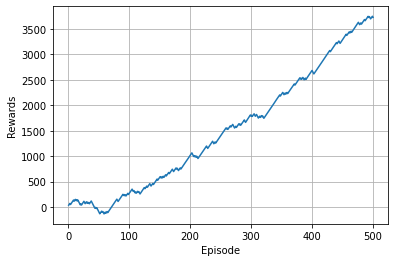

goal episode 501 step= 152
shout entos periohis Ball Position 1.0103152 -0.03327348 0.13086735 episode 501 step= 152


In [ ]:

env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')
num_games =601

load_checkpoint =False
Action_list=[4,5,6,12]
agent=Agent(gamma=0.99 , epsilon = 1.0 , alpha = 0.00115 , input_dims = [10] , n_actions = len(Action_list) ,mem_size =1000000,eps_min=0.01,batch_size =64 
                  ,eps_dec=1e-3 , replace =100)

all_prints = All_prints()
if load_checkpoint:
  agent.load_models()

filename='ddqn_gfootball.png'
scores=[]
eps_history=[]
steps=0
terminal =0
episode =0
shout =0

eps_rew=0
rew_list = []
step_list =[]
score_list=[]
total_rewards = []

for i in range(num_games):
  done = False 
  score = 0
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")

 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    
    if(done ==1 and reward != 1): #if ball is out ,loses -10
      
      reward = reward -10
      print("ball is out -10","episode",i,"Ball Position",observation[4],observation[5],observation[6],"step=",steps)

    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward = reward + 30

    #if((observation[0]<0.5)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      #reward= reward -200
      #done=1
      #print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.6) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis Ball Position",observation[4],observation[5],observation[6],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.2) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
   
    score= +reward
    eps_rew+=reward
    agent.store_transition(observation,action,reward,new_observation , int(done))

    agent.learn()
    observation = new_observation
    steps=steps+1

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)



  scores.append(score)
  avg_score = np.mean(scores[-100:])

  #print('episode',i,'score %.1f average score %.1f epsilon %2.f' %(score,avg_score,agent.epsilon))

  

  episode = episode +1 

  rew_list.append(eps_rew)
  # PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)

  


  eps_history.append(agent.epsilon)

x=[i + 1 for i in range(num_games)]
#plotLearning(x,scores,eps_history,filename)
